In [1]:
import pandas as pd
import numpy as np
import keras
import os
from src.constants import Constants2, params_blog_2, hyperparameter_space
import warnings
from keras.models import Sequential
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, multiply, Dropout # for creating regular densely-connected NN layers.
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_poisson_deviance
from typing import *
from time import time
from src.utils import *
from collections import defaultdict
from pprint import pprint
import random
import shap
import math
from mango import Tuner
from itertools import product
from hyperopt import hp, fmin, tpe
import matplotlib.pyplot as plt

In [2]:
# https://github.com/RonRichman/AI_in_Actuarial_Science/blob/master/NL%20Pricing/Keras%20-%20NL%20Pricing%20-%20NN_embed_transfer.R#L177
# https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/
# https://towardsdatascience.com/interpretability-of-deep-learning-models-9f52e54d72ab
# https://towardsdatascience.com/feed-forward-neural-networks-how-to-successfully-build-them-in-python-74503409d99a

In [3]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.4f}'.format)
pd.set_option("display.precision", 4)

In [4]:
RANDOM_STATE = params_blog_2.get(Constants2.RANDOM_STATE)
TEST_SIZE = params_blog_2.get(Constants2.TEST_SIZE)
VAL_SIZE = params_blog_2.get(Constants2.VAL_SIZE_FROM_TRAIN_SIZE)
N_ITER_SKLEARN_HYPEROPT = params_blog_2.get(Constants2.N_ITER_SKLEARN_HYPEROPT)
N_ITER= N_ITER_SKLEARN_HYPEROPT

In [5]:
PATH_TO_DATA = params_blog_2.get(Constants2.PATH_TO_DATA)
nb_claims_name, claim_amount_name = params_blog_2.get(Constants2.NB_CLAIMS), params_blog_2.get(Constants2.CLAIM_AMOUNT)
claim_frequency_name = params_blog_2.get(Constants2.CLAIM_FREQUENCY)
exposure_name = params_blog_2.get(Constants2.EXPOSURE_NAME)

In [6]:
df_freq = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_2.get(Constants2.DATASET_FREQ_NAME)))
df_sev = pd.read_pickle(os.path.join(PATH_TO_DATA, params_blog_2.get(Constants2.DATASET_SEV_NAME)))

In [7]:
df_freq.head(2).transpose()

,0,1
ClaimNb,0.0000,0.0000
Exposure,0.0900,0.8400
ClaimAmount,0.0000,0.0000
claim_frequency,0.0000,0.0000
power_d,0.0000,0.0000
power_e,0.0000,0.0000
power_f,0.0000,0.0000
power_g,1.0000,1.0000
power_h,0.0000,0.0000
power_i,0.0000,0.0000


In [8]:
nb_claims, claim_amount = df_freq[nb_claims_name], df_freq[claim_amount_name]
X = df_freq.drop(columns=[claim_amount_name, claim_frequency_name])

In [9]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, nb_claims, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=X[nb_claims_name])


In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, 
                                                    test_size=VAL_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=x_train_val[nb_claims_name])

In [11]:
exp_train, exp_val, exp_test = x_train[exposure_name], x_val[exposure_name], x_test[exposure_name]

In [12]:
x_train = x_train.drop(columns=[nb_claims_name])
x_val = x_val.drop(columns=[nb_claims_name])
x_test = x_test.drop(columns=[nb_claims_name])

In [13]:
start_time = time()
results, best_model = run_optimization_neural_network(x_train, y_train, x_val, y_val, x_test, y_test, 
                                                      exp_test, hyperparameter_space,
                                                      n_max_experiments=params_blog_2.get(Constants2.N_MAX_EXPERIMENTS),
                                                      max_optimization_time=params_blog_2.get(Constants2.MAX_OPTIMIZATION_TIME),
                                                     )
opt_time = (time() - start_time)/60

-------------------------------------------------- 0th EXPERIMENT --------------------------------------------------
{'batch_size': 256,
 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>],
 'layer_param_0': {'activation': 'sigmoid',
                   'dropout_rate': 0.15000000000000002,
                   'kernel_initializer': 'glorot_uniform',
                   'units': 100,
                   'use_bias': True},
 'layer_param_1': {'activation': 'softmax',
                   'dropout_rate': 0.24000000000000002,
                   'kernel_initializer': 'glorot_uniform',
                   'units': 45,
                   'use_bias': True},
 'nb_hidden_layers': 2,
 'optimizer': 'adam'}
Epoch 1/10
1163/1163 [==============================] - 4s 3ms/step - loss: 0.3761 - poisson: 0.3761 - val_loss: 0.2132 - val_poisson: 0.2132
Epoch 2/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.2075 - poisson: 0.2075 - val_loss: 0.1719 - val_poisson: 0.1

1163/1163 [==============================] - 3s 2ms/step - loss: 0.2802 - poisson: 0.2802 - val_loss: 0.1777 - val_poisson: 0.1777
Epoch 2/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.2008 - poisson: 0.2008 - val_loss: 0.1664 - val_poisson: 0.1664
Epoch 3/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1853 - poisson: 0.1853 - val_loss: 0.1659 - val_poisson: 0.1659
Epoch 4/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1774 - poisson: 0.1774 - val_loss: 0.1659 - val_poisson: 0.1659
Epoch 5/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1722 - poisson: 0.1722 - val_loss: 0.1659 - val_poisson: 0.1659
Epoch 6/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1691 - poisson: 0.1691 - val_loss: 0.1659 - val_poisson: 0.1659
Epoch 7/10
1163/1163 [==============================] - 3s 3ms/step - loss: 0.1676 - poisson: 0.1676 - val_loss: 0.1659 - val_poisson: 0.1659
Epoch 8/10
1163/1

1163/1163 [==============================] - 3s 2ms/step - loss: 0.1632 - poisson: 0.1632 - val_loss: 0.1609 - val_poisson: 0.1609
Epoch 8/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1625 - poisson: 0.1625 - val_loss: 0.1610 - val_poisson: 0.1610
Epoch 9/10
1163/1163 [==============================] - 3s 2ms/step - loss: 0.1618 - poisson: 0.1618 - val_loss: 0.1608 - val_poisson: 0.1608
Epoch 10/10
2583/2583 [==============================] - 2s 818us/step
-------------------------------------------------- 5th EXPERIMENT --------------------------------------------------
{'batch_size': 256,
 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>],
 'layer_param_0': {'activation': None,
                   'dropout_rate': 0.11,
                   'kernel_initializer': 'glorot_uniform',
                   'units': 25,
                   'use_bias': True},
 'nb_hidden_layers': 1,
 'optimizer': 'adam'}
Epoch 1/10
1163/1163 [======================

In [14]:
results.reset_index(inplace=True, drop=True)
results.head(5)

,selected_hyperparams,poisson_dev
0,"{'nb_hidden_layers': 2, 'optimizer': 'adam', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>], 'batch_size': 256, 'layer_param_0': {'units': 100, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_1': {'units': 100, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}}",0.2974
1,"{'nb_hidden_layers': 2, 'optimizer': 'adam', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>], 'batch_size': 256, 'layer_param_0': {'units': 40, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_1': {'units': 20, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}}",0.2976
2,"{'nb_hidden_layers': 3, 'optimizer': 'adam', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>], 'batch_size': 256, 'layer_param_0': {'units': 30, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_1': {'units': 2, 'activation': None, 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_2': {'units': 40, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}}",0.2983
3,"{'nb_hidden_layers': 2, 'optimizer': 'adam', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>], 'batch_size': 256, 'layer_param_0': {'units': 100, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_1': {'units': 45, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}}",0.2993
4,"{'nb_hidden_layers': 2, 'optimizer': 'adam', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001A0142C5310>], 'batch_size': 256, 'layer_param_0': {'units': 50, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}, 'layer_param_1': {'units': 45, 'activation': None, 'use_bias': True, 'kernel_initializer': 'glorot_uniform'}}",0.2997


In [15]:
results.head(1).selected_hyperparams.squeeze()

{'nb_hidden_layers': 2,
 'optimizer': 'adam',
 'callbacks': [<keras.callbacks.EarlyStopping at 0x1a0142c5310>],
 'batch_size': 256,
 'layer_param_0': {'units': 100,
  'activation': 'relu',
  'use_bias': True,
  'kernel_initializer': 'glorot_uniform'},
 'layer_param_1': {'units': 100,
  'activation': 'softmax',
  'use_bias': True,
  'kernel_initializer': 'glorot_uniform'}}

In [16]:
list(product(hyperparameter_space.get('activation'), \
             hyperparameter_space.get('units'),\
#              [50],
             hyperparameter_space.get('dropout_rate')
#   [0.5]
             ))

[('sigmoid', 2, 0.01),
 ('sigmoid', 2, 0.02),
 ('sigmoid', 2, 0.03),
 ('sigmoid', 2, 0.04),
 ('sigmoid', 2, 0.05),
 ('sigmoid', 2, 0.060000000000000005),
 ('sigmoid', 2, 0.06999999999999999),
 ('sigmoid', 2, 0.08),
 ('sigmoid', 2, 0.09),
 ('sigmoid', 2, 0.09999999999999999),
 ('sigmoid', 2, 0.11),
 ('sigmoid', 2, 0.12),
 ('sigmoid', 2, 0.13),
 ('sigmoid', 2, 0.14),
 ('sigmoid', 2, 0.15000000000000002),
 ('sigmoid', 2, 0.16),
 ('sigmoid', 2, 0.17),
 ('sigmoid', 2, 0.18000000000000002),
 ('sigmoid', 2, 0.19),
 ('sigmoid', 2, 0.2),
 ('sigmoid', 2, 0.21000000000000002),
 ('sigmoid', 2, 0.22),
 ('sigmoid', 2, 0.23),
 ('sigmoid', 2, 0.24000000000000002),
 ('sigmoid', 2, 0.25),
 ('sigmoid', 2, 0.26),
 ('sigmoid', 2, 0.27),
 ('sigmoid', 2, 0.28),
 ('sigmoid', 2, 0.29000000000000004),
 ('sigmoid', 2, 0.3),
 ('sigmoid', 2, 0.31),
 ('sigmoid', 2, 0.32),
 ('sigmoid', 2, 0.33),
 ('sigmoid', 2, 0.34),
 ('sigmoid', 2, 0.35000000000000003),
 ('sigmoid', 2, 0.36000000000000004),
 ('sigmoid', 2, 0.37),


In [17]:
hyperparameter_space_mango_opt = {
    'nb_hidden_layers': [3],
    'layer_param_0':[{'dropout_rate':dropout_rate, \
                      'units':unit, \
                      'activation':activation, \
                      'use_bias':True, \
                      'kernel_initializer':'glorot_uniform'} 
                     
                     for activation, unit, dropout_rate in 
                     list(product(hyperparameter_space.get('activation'), \
                     hyperparameter_space.get('units'),\
                     hyperparameter_space.get('dropout_rate')
            ))
                    
                    ],
    
    'optimizer': ['adam'],
 'callbacks': [hyperparameter_space.get('callbacks')],
 'batch_size': [256]
    
    
}
hyperparameter_space_mango_opt['layer_param_1'] = hyperparameter_space_mango_opt.get('layer_param_0')
hyperparameter_space_mango_opt['layer_param_2'] = hyperparameter_space_mango_opt.get('layer_param_0')

In [18]:

# @scheduler.parallel(n_jobs=N_JOBS_MANGO_PARALLEL)
def objective_nn(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = fit_feed_forward_neural_network(
            x_train, y_train, x_val, y_val, params=hyperparams
        )
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

In [19]:
tuner = Tuner(hyperparameter_space_mango_opt, objective_nn, dict(num_iteration=1, initial_random=41))  # Initialize Tuner

In [20]:
# optimisation_results = tuner.minimize() 

### 3. Bayesian optimization with Hyperopt

In [21]:
def f(x):
    return x**2 + x + 1

In [22]:
space = hp.uniform('x', -2, 2)

In [23]:
best = fmin(
    fn=f,  
    space=space,
    algo=tpe.suggest,
    max_evals=1000
)

print(f"Optimal value of x: {best}")

 ... (more hidden) ...
Optimal value of x: {'x': -0.5002999730043602}


In [24]:
space

In [25]:
x=np.linspace(-100, 100, 10000)

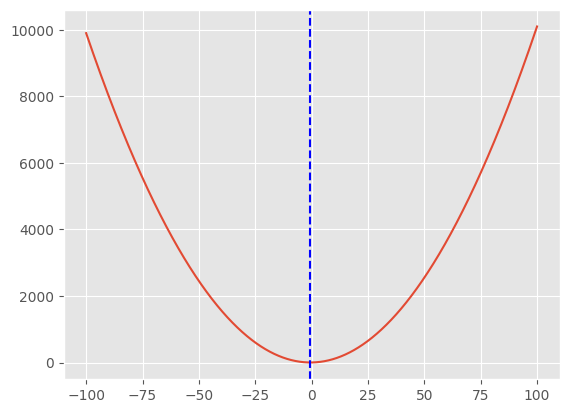

In [26]:
plt.plot(x, f(x))
plt.axvline(best.get('x'), linestyle='dashed', color='blue')
plt.show()